In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np

In [4]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Mohtat2020)
param = pybamm.LithiumIonParameters()
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)
Cn

5.973262521249683

## Initialize model at full charge to 4.1V

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)
parameter_values.update({
    "SEI kinetic rate constant [m.s-1]": 1e-15,
    "SEI resistivity [Ohm.m]": 0,
})
spm = pybamm.lithium_ion.SPM({"SEI": "ec reaction limited"})

In [3]:
esoh_model = pybamm.lithium_ion.ElectrodeSOH()
esoh_sim = pybamm.Simulation(esoh_model, parameter_values=parameter_values)
param = spm.param

Vmin = 2.5
Vmax = 4.2
Cn = parameter_values.evaluate(param.C_n_init)
Cp = parameter_values.evaluate(param.C_p_init)
n_Li_init = parameter_values.evaluate(param.n_Li_particles_init)
c_n_max = parameter_values.evaluate(param.c_n_max)
c_p_max = parameter_values.evaluate(param.c_p_max)

esoh_sol = esoh_sim.solve(
    [0],
    inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li_init},
)
print(esoh_sol["x_100"].data[0])
print(esoh_sol["y_100"].data[0])

0.9045388808869798
0.26790222708570466


## One cycle

In [4]:
parameter_values.update(
    {
        "Initial concentration in negative electrode [mol.m-3]": esoh_sol["x_100"].data[0] * c_n_max,
        "Initial concentration in positive electrode [mol.m-3]": esoh_sol["y_100"].data[0] * c_p_max,
    }
)
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

In [5]:
spm_sol.plot(["Terminal voltage [V]"])

interactive(children=(FloatSlider(value=0.0, description='t', max=3.614634167152469, step=0.03614634167152469)…

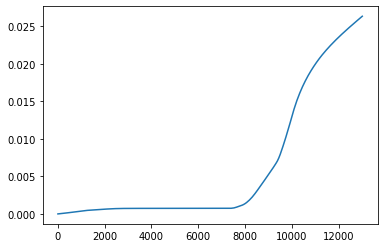

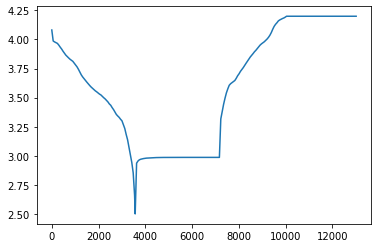

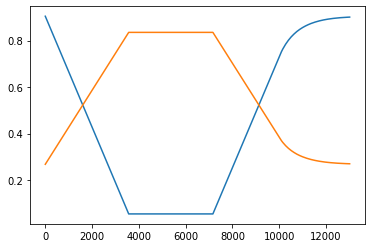

In [6]:
plt.plot(spm_sol["Time [s]"].data, spm_sol["Loss of Lithium Inventory [%]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Terminal voltage [V]"].data)
plt.figure()
plt.plot(spm_sol["Time [s]"].data, spm_sol["Negative electrode SOC"].data)
plt.plot(spm_sol["Time [s]"].data, spm_sol["Positive electrode SOC"].data)

In [7]:
lli = spm_sol["Loss of Lithium Inventory [%]"].data
lli_one_cycle = lli[-1] - lli[0]

## 10 cycles

In [68]:
pybamm.set_logging_level("NOTICE")
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
    f"Charge at 1C until {Vmax}V", 
    f"Hold at {Vmax}V until C/50")
] * 500)
sim_100 = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol_100 = sim_100.solve()

2021-02-19 22:07:02,841 - [NOTICE] simulation.solve(499): Cycle 1/500 (29.281 ms elapsed) --------------------
2021-02-19 22:07:02,842 - [NOTICE] simulation.solve(526): Cycle 1/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:07:03,161 - [NOTICE] simulation.solve(526): Cycle 1/500, step 2/4: Rest for 1 hour
2021-02-19 22:07:03,415 - [NOTICE] simulation.solve(526): Cycle 1/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:07:03,669 - [NOTICE] simulation.solve(526): Cycle 1/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:07:04,137 - [NOTICE] simulation.solve(499): Cycle 2/500 (1.326 s elapsed) --------------------
2021-02-19 22:07:04,138 - [NOTICE] simulation.solve(526): Cycle 2/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:07:04,402 - [NOTICE] simulation.solve(526): Cycle 2/500, step 2/4: Rest for 1 hour
2021-02-19 22:07:04,616 - [NOTICE] simulation.solve(526): Cycle 2/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:07:04,839 - [NOTICE] simulation.solve(526

2021-02-19 22:07:21,578 - [NOTICE] simulation.solve(526): Cycle 16/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:07:21,822 - [NOTICE] simulation.solve(526): Cycle 16/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:07:22,224 - [NOTICE] simulation.solve(499): Cycle 17/500 (19.411 s elapsed) --------------------
2021-02-19 22:07:22,224 - [NOTICE] simulation.solve(526): Cycle 17/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:07:22,485 - [NOTICE] simulation.solve(526): Cycle 17/500, step 2/4: Rest for 1 hour
2021-02-19 22:07:22,711 - [NOTICE] simulation.solve(526): Cycle 17/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:07:22,936 - [NOTICE] simulation.solve(526): Cycle 17/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:07:23,331 - [NOTICE] simulation.solve(499): Cycle 18/500 (20.518 s elapsed) --------------------
2021-02-19 22:07:23,331 - [NOTICE] simulation.solve(526): Cycle 18/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:07:23,593 - [NOTICE] sim

2021-02-19 22:07:40,553 - [NOTICE] simulation.solve(526): Cycle 32/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:07:40,819 - [NOTICE] simulation.solve(526): Cycle 32/500, step 2/4: Rest for 1 hour
2021-02-19 22:07:41,077 - [NOTICE] simulation.solve(526): Cycle 32/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:07:41,312 - [NOTICE] simulation.solve(526): Cycle 32/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:07:41,768 - [NOTICE] simulation.solve(499): Cycle 33/500 (38.956 s elapsed) --------------------
2021-02-19 22:07:41,769 - [NOTICE] simulation.solve(526): Cycle 33/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:07:42,066 - [NOTICE] simulation.solve(526): Cycle 33/500, step 2/4: Rest for 1 hour
2021-02-19 22:07:42,351 - [NOTICE] simulation.solve(526): Cycle 33/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:07:42,590 - [NOTICE] simulation.solve(526): Cycle 33/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:07:43,074 - [NOTICE] simulation.solve

2021-02-19 22:07:59,520 - [NOTICE] simulation.solve(526): Cycle 47/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:08:00,025 - [NOTICE] simulation.solve(499): Cycle 48/500 (57.212 s elapsed) --------------------
2021-02-19 22:08:00,026 - [NOTICE] simulation.solve(526): Cycle 48/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:08:00,274 - [NOTICE] simulation.solve(526): Cycle 48/500, step 2/4: Rest for 1 hour
2021-02-19 22:08:00,506 - [NOTICE] simulation.solve(526): Cycle 48/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:08:00,728 - [NOTICE] simulation.solve(526): Cycle 48/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:08:01,162 - [NOTICE] simulation.solve(499): Cycle 49/500 (58.349 s elapsed) --------------------
2021-02-19 22:08:01,163 - [NOTICE] simulation.solve(526): Cycle 49/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:08:01,435 - [NOTICE] simulation.solve(526): Cycle 49/500, step 2/4: Rest for 1 hour
2021-02-19 22:08:01,692 - [NOTICE] simulation.

2021-02-19 22:08:18,055 - [NOTICE] simulation.solve(526): Cycle 63/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:08:18,318 - [NOTICE] simulation.solve(526): Cycle 63/500, step 2/4: Rest for 1 hour
2021-02-19 22:08:18,560 - [NOTICE] simulation.solve(526): Cycle 63/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:08:18,777 - [NOTICE] simulation.solve(526): Cycle 63/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:08:19,237 - [NOTICE] simulation.solve(499): Cycle 64/500 (1 minute, 16 seconds elapsed) --------------------
2021-02-19 22:08:19,238 - [NOTICE] simulation.solve(526): Cycle 64/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:08:19,494 - [NOTICE] simulation.solve(526): Cycle 64/500, step 2/4: Rest for 1 hour
2021-02-19 22:08:19,748 - [NOTICE] simulation.solve(526): Cycle 64/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:08:19,979 - [NOTICE] simulation.solve(526): Cycle 64/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:08:20,427 - [NOTICE] simu

2021-02-19 22:08:36,228 - [NOTICE] simulation.solve(526): Cycle 78/500, step 2/4: Rest for 1 hour
2021-02-19 22:08:36,477 - [NOTICE] simulation.solve(526): Cycle 78/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:08:36,715 - [NOTICE] simulation.solve(526): Cycle 78/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:08:37,149 - [NOTICE] simulation.solve(499): Cycle 79/500 (1 minute, 34 seconds elapsed) --------------------
2021-02-19 22:08:37,150 - [NOTICE] simulation.solve(526): Cycle 79/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:08:37,405 - [NOTICE] simulation.solve(526): Cycle 79/500, step 2/4: Rest for 1 hour
2021-02-19 22:08:37,644 - [NOTICE] simulation.solve(526): Cycle 79/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:08:37,854 - [NOTICE] simulation.solve(526): Cycle 79/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:08:38,293 - [NOTICE] simulation.solve(499): Cycle 80/500 (1 minute, 35 seconds elapsed) --------------------
2021-02-19 22:08:38,293 -

2021-02-19 22:08:55,182 - [NOTICE] simulation.solve(526): Cycle 93/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:08:55,434 - [NOTICE] simulation.solve(526): Cycle 93/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:08:56,030 - [NOTICE] simulation.solve(499): Cycle 94/500 (1 minute, 53 seconds elapsed) --------------------
2021-02-19 22:08:56,030 - [NOTICE] simulation.solve(526): Cycle 94/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:08:56,332 - [NOTICE] simulation.solve(526): Cycle 94/500, step 2/4: Rest for 1 hour
2021-02-19 22:08:56,572 - [NOTICE] simulation.solve(526): Cycle 94/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:08:56,817 - [NOTICE] simulation.solve(526): Cycle 94/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:08:57,249 - [NOTICE] simulation.solve(499): Cycle 95/500 (1 minute, 54 seconds elapsed) --------------------
2021-02-19 22:08:57,249 - [NOTICE] simulation.solve(526): Cycle 95/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:

2021-02-19 22:09:14,215 - [NOTICE] simulation.solve(526): Cycle 108/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:09:14,670 - [NOTICE] simulation.solve(499): Cycle 109/500 (2 minutes, 12 seconds elapsed) --------------------
2021-02-19 22:09:14,671 - [NOTICE] simulation.solve(526): Cycle 109/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:09:14,972 - [NOTICE] simulation.solve(526): Cycle 109/500, step 2/4: Rest for 1 hour
2021-02-19 22:09:15,210 - [NOTICE] simulation.solve(526): Cycle 109/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:09:15,428 - [NOTICE] simulation.solve(526): Cycle 109/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:09:15,865 - [NOTICE] simulation.solve(499): Cycle 110/500 (2 minutes, 13 seconds elapsed) --------------------
2021-02-19 22:09:15,866 - [NOTICE] simulation.solve(526): Cycle 110/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:09:16,115 - [NOTICE] simulation.solve(526): Cycle 110/500, step 2/4: Rest for 1 hour
2021-02-19 

2021-02-19 22:09:32,435 - [NOTICE] simulation.solve(526): Cycle 123/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:09:32,927 - [NOTICE] simulation.solve(499): Cycle 124/500 (2 minutes, 30 seconds elapsed) --------------------
2021-02-19 22:09:32,927 - [NOTICE] simulation.solve(526): Cycle 124/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:09:33,193 - [NOTICE] simulation.solve(526): Cycle 124/500, step 2/4: Rest for 1 hour
2021-02-19 22:09:33,428 - [NOTICE] simulation.solve(526): Cycle 124/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:09:33,671 - [NOTICE] simulation.solve(526): Cycle 124/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:09:34,123 - [NOTICE] simulation.solve(499): Cycle 125/500 (2 minutes, 31 seconds elapsed) --------------------
2021-02-19 22:09:34,124 - [NOTICE] simulation.solve(526): Cycle 125/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:09:34,373 - [NOTICE] simulation.solve(526): Cycle 125/500, step 2/4: Rest for 1 hour
2021-02-19 

2021-02-19 22:09:51,095 - [NOTICE] simulation.solve(526): Cycle 138/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:09:51,573 - [NOTICE] simulation.solve(499): Cycle 139/500 (2 minutes, 49 seconds elapsed) --------------------
2021-02-19 22:09:51,574 - [NOTICE] simulation.solve(526): Cycle 139/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:09:51,854 - [NOTICE] simulation.solve(526): Cycle 139/500, step 2/4: Rest for 1 hour
2021-02-19 22:09:52,123 - [NOTICE] simulation.solve(526): Cycle 139/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:09:52,356 - [NOTICE] simulation.solve(526): Cycle 139/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:09:52,786 - [NOTICE] simulation.solve(499): Cycle 140/500 (2 minutes, 50 seconds elapsed) --------------------
2021-02-19 22:09:52,786 - [NOTICE] simulation.solve(526): Cycle 140/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:09:53,082 - [NOTICE] simulation.solve(526): Cycle 140/500, step 2/4: Rest for 1 hour
2021-02-19 

2021-02-19 22:10:09,113 - [NOTICE] simulation.solve(526): Cycle 153/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:10:09,583 - [NOTICE] simulation.solve(499): Cycle 154/500 (3 minutes, 7 seconds elapsed) --------------------
2021-02-19 22:10:09,583 - [NOTICE] simulation.solve(526): Cycle 154/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:10:09,850 - [NOTICE] simulation.solve(526): Cycle 154/500, step 2/4: Rest for 1 hour
2021-02-19 22:10:10,084 - [NOTICE] simulation.solve(526): Cycle 154/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:10:10,313 - [NOTICE] simulation.solve(526): Cycle 154/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:10:10,743 - [NOTICE] simulation.solve(499): Cycle 155/500 (3 minutes, 8 seconds elapsed) --------------------
2021-02-19 22:10:10,744 - [NOTICE] simulation.solve(526): Cycle 155/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:10:10,993 - [NOTICE] simulation.solve(526): Cycle 155/500, step 2/4: Rest for 1 hour
2021-02-19 22

2021-02-19 22:10:27,609 - [NOTICE] simulation.solve(526): Cycle 168/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:10:28,043 - [NOTICE] simulation.solve(499): Cycle 169/500 (3 minutes, 25 seconds elapsed) --------------------
2021-02-19 22:10:28,044 - [NOTICE] simulation.solve(526): Cycle 169/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:10:28,294 - [NOTICE] simulation.solve(526): Cycle 169/500, step 2/4: Rest for 1 hour
2021-02-19 22:10:28,537 - [NOTICE] simulation.solve(526): Cycle 169/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:10:28,766 - [NOTICE] simulation.solve(526): Cycle 169/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:10:29,178 - [NOTICE] simulation.solve(499): Cycle 170/500 (3 minutes, 26 seconds elapsed) --------------------
2021-02-19 22:10:29,178 - [NOTICE] simulation.solve(526): Cycle 170/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:10:29,439 - [NOTICE] simulation.solve(526): Cycle 170/500, step 2/4: Rest for 1 hour
2021-02-19 

2021-02-19 22:10:45,352 - [NOTICE] simulation.solve(526): Cycle 183/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:10:45,784 - [NOTICE] simulation.solve(499): Cycle 184/500 (3 minutes, 43 seconds elapsed) --------------------
2021-02-19 22:10:45,784 - [NOTICE] simulation.solve(526): Cycle 184/500, step 1/4: Discharge at 1C until 2.5V
2021-02-19 22:10:46,025 - [NOTICE] simulation.solve(526): Cycle 184/500, step 2/4: Rest for 1 hour
2021-02-19 22:10:46,276 - [NOTICE] simulation.solve(526): Cycle 184/500, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:10:46,496 - [NOTICE] simulation.solve(526): Cycle 184/500, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:10:46,733 - [WARNING] simulation.solve(555): 

	Experiment is infeasible: 'event: Zero negative electrode porosity cut-off' was triggered during 'Hold at 4.2V until C/50'. Try reducing current, shortening the time interval, or reducing the period.


CasADi - 2021-02-19 22:10:46 WARNING("roots:jac_f_z failed: NaN detected for outp

SolverError: Could not find acceptable solution: solver returned NaNs

In [70]:
len(spm_sol_100.cycles)

100

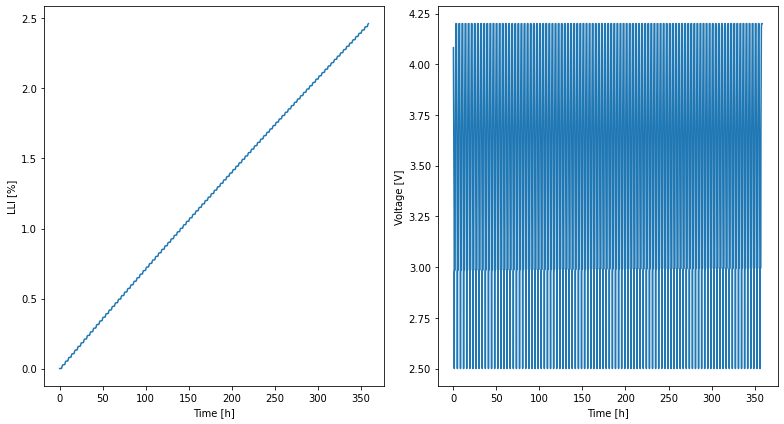

In [9]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100["Time [h]"].data, spm_sol_100["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
OUTPUT_DIR = "/Users/vsulzer/Google Drive/PCL_Sulzer/"
fig.savefig(OUTPUT_DIR + "100_cycles.eps", dpi=1000)

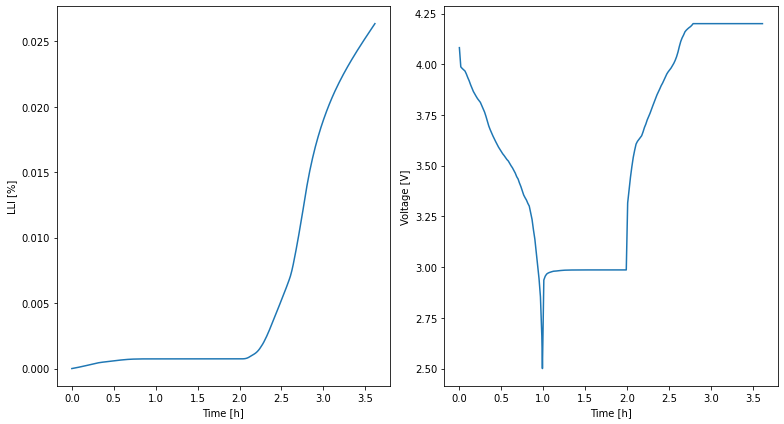

In [10]:
fig, ax = plt.subplots(1,2,figsize=(11,6))

ax[0].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Loss of Lithium Inventory [%]"].data)
ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")
ax[1].plot(spm_sol_100.cycles[0]["Time [h]"].data, spm_sol_100.cycles[0]["Terminal voltage [V]"].data)
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "first_cycle.eps", dpi=1000)

In [11]:
lli_100 = spm_sol_100["Loss of Lithium Inventory [%]"].data
lli_100_cycles = lli_100[-1] - lli_100[0]

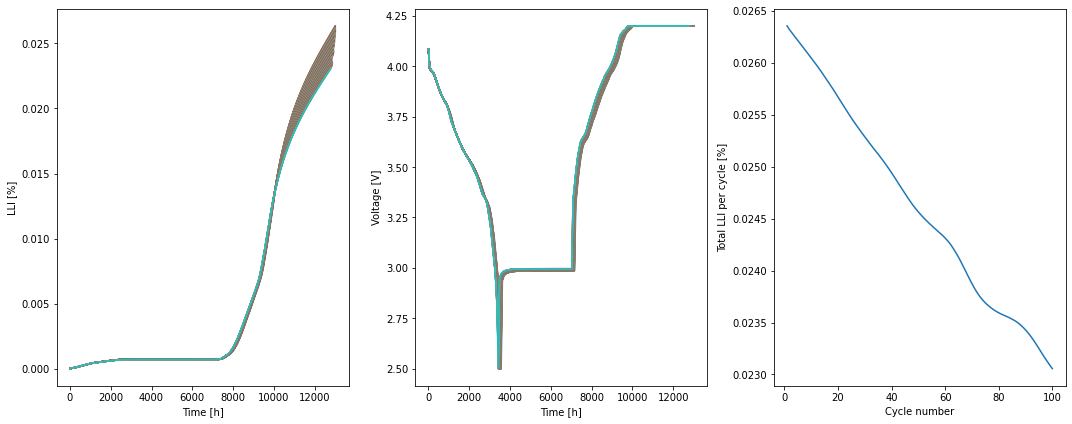

In [12]:

fig, ax = plt.subplots(1,3,figsize=(15,6))

all_lli = []
for cycle in spm_sol_100.cycles:
    t = cycle["Time [s]"].data
    lli = cycle["Loss of Lithium Inventory [%]"].data
    V = cycle["Terminal voltage [V]"].data

    ax[0].plot(t - t[0], lli-lli[0])
    ax[1].plot(t-t[0], V)
    
    all_lli.append(lli[-1]-lli[0])

ax[0].set_xlabel("Time [h]")
ax[0].set_ylabel("LLI [%]")    
ax[1].set_xlabel("Time [h]")
ax[1].set_ylabel("Voltage [V]")

ax[2].plot(range(1, len(all_lli)+1), all_lli)
ax[2].set_xlabel("Cycle number")
ax[2].set_ylabel("Total LLI per cycle [%]")

fig.tight_layout()
fig.savefig(OUTPUT_DIR + "cycles_comparison.eps", dpi=1000)

### eSOH parameters


In [13]:
len(spm_sol_100.summary_variables.items())

71

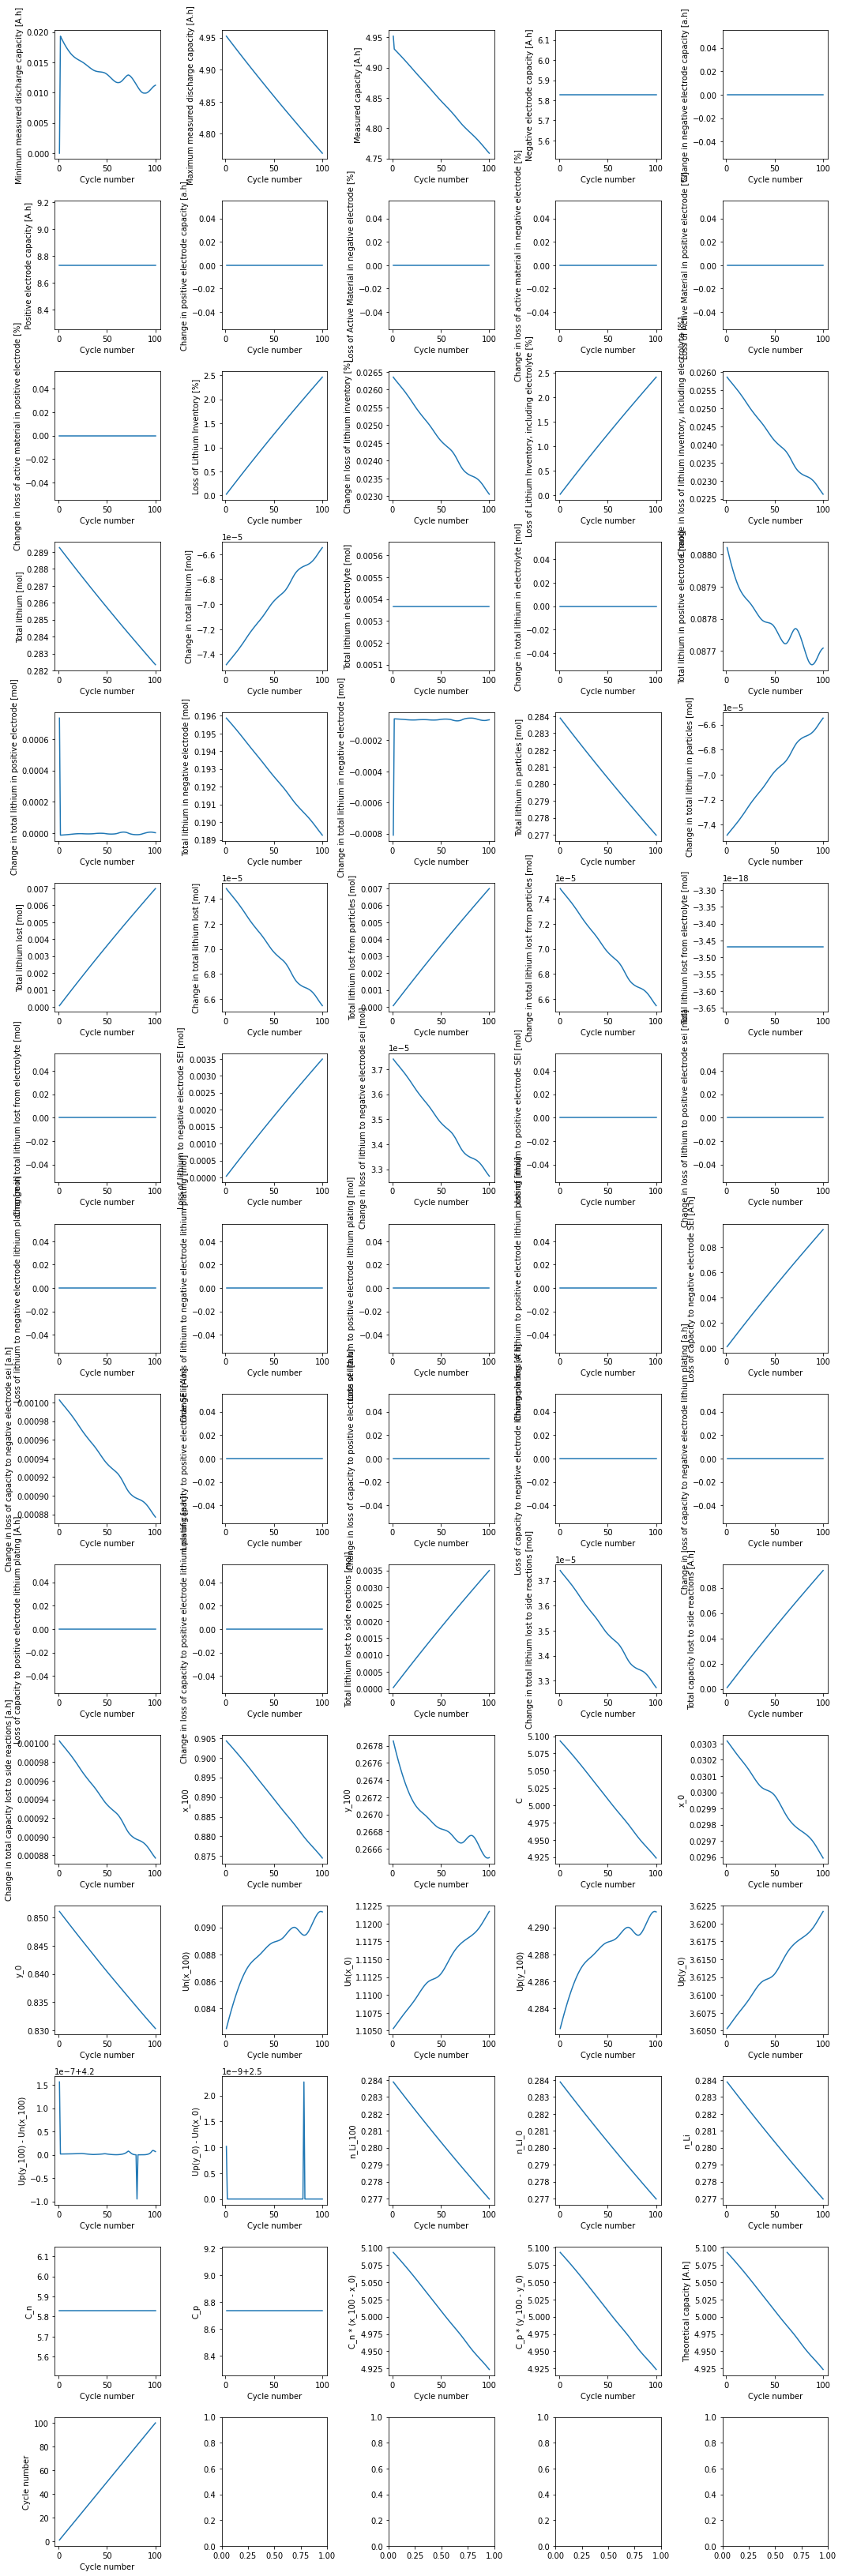

In [14]:
fig, axes = plt.subplots(15,5,figsize=(15,45))

for k, (name,val) in enumerate(spm_sol_100.summary_variables.items()):
    ax = axes.flat[k]
    ax.plot(spm_sol_100.summary_variables["Cycle number"],val)
    ax.set_xlabel("Cycle number")
    ax.set_ylabel(name)

# axes.flat[4].plot(range(1,101), all_nLi)
# axes.flat[4].set_xlabel("Cycle number")
# axes.flat[4].set_ylabel("n_Li")
# axes.flat[-1].plot(range(1,101), all_C)
# axes.flat[-1].set_xlabel("Cycle number")
# axes.flat[-1].set_ylabel("C")
# axes.flat[-1].set_ylim([2,5])
# axes.flat[-2].set_ylim([2,5])

fig.tight_layout()

## Accelerated simulations algorithm

### Constant extrapolation

Solve for 1 cycle

In [15]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])
sim = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
spm_sol = sim.solve()

2021-02-19 21:33:56,262 - [NOTICE] simulation.solve(499): Cycle 1/1 (21.924 ms elapsed) --------------------
2021-02-19 21:33:56,263 - [NOTICE] simulation.solve(526): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V
2021-02-19 21:33:56,581 - [NOTICE] simulation.solve(526): Cycle 1/1, step 2/4: Rest for 1 hour
2021-02-19 21:33:56,844 - [NOTICE] simulation.solve(526): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-02-19 21:33:57,051 - [NOTICE] simulation.solve(526): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-02-19 21:33:57,507 - [NOTICE] simulation.solve(580): Finish experiment simulation, took 1.266 s


Check how well extrapolating 1 cycle does

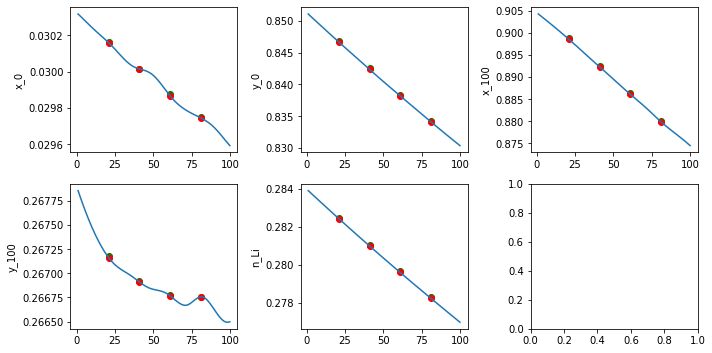

In [16]:
n_cycles_step = 20
cycle = 0

esoh_vars = ["x_0", "y_0", "x_100", "y_100", "n_Li"]

fig, ax = plt.subplots(2,3,figsize=(10,5))
for k, name in enumerate(esoh_vars):
    ax.flat[k].plot(spm_sol_100.summary_variables["Cycle number"], spm_sol_100.summary_variables[name])
    ax.flat[k].set_ylabel(name)

while cycle < len(spm_sol_100.cycles)-n_cycles_step:
    n_Li_cycle = spm_sol_100.cycles[cycle]["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    
    cycle += n_cycles_step
    for k, name in enumerate(esoh_vars):
        ax.flat[k].scatter(cycle+1,esoh_sol[name].data[0],color="g")
        ax.flat[k].scatter(cycle+1,spm_sol_100.summary_variables[name][cycle],color="r")
        
fig.tight_layout()

Use extrapolation to initialize next simulation

In [80]:
experiment = pybamm.Experiment([
    (f"Discharge at 1C until {Vmin}V",
     "Rest for 1 hour",
     f"Charge at 1C until {Vmax}V", 
     f"Hold at {Vmax}V until C/50")
])

sim_acc = pybamm.Simulation(spm, experiment=experiment, parameter_values=parameter_values)
sim_acc.build()

In [81]:
sol_acc = []
cycle_nums = []
cycle = 0
while cycle < 100:
    print(cycle)
    # Simulate one cycle
    sol = sim_acc.solve()
    
    n_Li_cycle = sol["Total lithium in particles [mol]"].data
    n_Li_cycle_init = n_Li_cycle[0]
    delta_nLi_cycle = n_Li_cycle[0] - n_Li_cycle[-1]
    
    n_Li = n_Li_cycle_init - delta_nLi_cycle * n_cycles_step

    esoh_sol = esoh_sim.solve(
        [0],
        inputs={"V_min": Vmin, "V_max": Vmax, "C_n": Cn, "C_p": Cp, "n_Li": n_Li},
    )
    ics = {}
    x_100 = esoh_sol["x_100"].data[0]
    y_100 = esoh_sol["y_100"].data[0]
    for var in sim_acc.built_model.initial_conditions:
        if var.name == "X-averaged negative particle concentration":
            ics[var.name] = x_100 * np.ones((sim_acc.built_model.variables[var.name].size, 2))
        elif var.name == "X-averaged positive particle concentration":
            ics[var.name] = y_100 * np.ones((sim_acc.built_model.variables[var.name].size, 2))
        else:
            ics[var.name] = sim_acc.solution[var.name].data
    sim_acc.built_model.set_initial_conditions_from(ics)

    cycle_nums.append(cycle)
    sol_acc.append(sol)
    cycle += n_cycles_step
        
fig.tight_layout()

2021-02-19 22:17:17,622 - [NOTICE] simulation.solve(499): Cycle 1/1 (32.535 ms elapsed) --------------------
2021-02-19 22:17:17,623 - [NOTICE] simulation.solve(526): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


0


2021-02-19 22:17:17,982 - [NOTICE] simulation.solve(526): Cycle 1/1, step 2/4: Rest for 1 hour
2021-02-19 22:17:18,219 - [NOTICE] simulation.solve(526): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:17:18,440 - [NOTICE] simulation.solve(526): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:17:18,977 - [NOTICE] simulation.solve(580): Finish experiment simulation, took 1.387 s
2021-02-19 22:17:19,055 - [NOTICE] simulation.solve(499): Cycle 1/1 (27.191 ms elapsed) --------------------
2021-02-19 22:17:19,055 - [NOTICE] simulation.solve(526): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


20


2021-02-19 22:17:19,358 - [NOTICE] simulation.solve(526): Cycle 1/1, step 2/4: Rest for 1 hour
2021-02-19 22:17:19,587 - [NOTICE] simulation.solve(526): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:17:19,814 - [NOTICE] simulation.solve(526): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:17:20,273 - [NOTICE] simulation.solve(580): Finish experiment simulation, took 1.245 s
2021-02-19 22:17:20,351 - [NOTICE] simulation.solve(499): Cycle 1/1 (25.773 ms elapsed) --------------------
2021-02-19 22:17:20,352 - [NOTICE] simulation.solve(526): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


40


2021-02-19 22:17:20,679 - [NOTICE] simulation.solve(526): Cycle 1/1, step 2/4: Rest for 1 hour
2021-02-19 22:17:20,943 - [NOTICE] simulation.solve(526): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:17:21,181 - [NOTICE] simulation.solve(526): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:17:21,709 - [NOTICE] simulation.solve(580): Finish experiment simulation, took 1.383 s
2021-02-19 22:17:21,784 - [NOTICE] simulation.solve(499): Cycle 1/1 (27.109 ms elapsed) --------------------
2021-02-19 22:17:21,784 - [NOTICE] simulation.solve(526): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


60


2021-02-19 22:17:22,089 - [NOTICE] simulation.solve(526): Cycle 1/1, step 2/4: Rest for 1 hour
2021-02-19 22:17:22,323 - [NOTICE] simulation.solve(526): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:17:22,547 - [NOTICE] simulation.solve(526): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:17:23,034 - [NOTICE] simulation.solve(580): Finish experiment simulation, took 1.278 s
2021-02-19 22:17:23,120 - [NOTICE] simulation.solve(499): Cycle 1/1 (28.712 ms elapsed) --------------------
2021-02-19 22:17:23,120 - [NOTICE] simulation.solve(526): Cycle 1/1, step 1/4: Discharge at 1C until 2.5V


80


2021-02-19 22:17:23,425 - [NOTICE] simulation.solve(526): Cycle 1/1, step 2/4: Rest for 1 hour
2021-02-19 22:17:23,695 - [NOTICE] simulation.solve(526): Cycle 1/1, step 3/4: Charge at 1C until 4.2V
2021-02-19 22:17:23,943 - [NOTICE] simulation.solve(526): Cycle 1/1, step 4/4: Hold at 4.2V until C/50
2021-02-19 22:17:24,490 - [NOTICE] simulation.solve(580): Finish experiment simulation, took 1.399 s


SolverError: CasADI solver failed because the following interpolation bounds were exceeded at the initial conditions: ['nmc_LGM50_ocp_Chen2020 lower bound']. You may need to provide additional interpolation points outside these bounds.

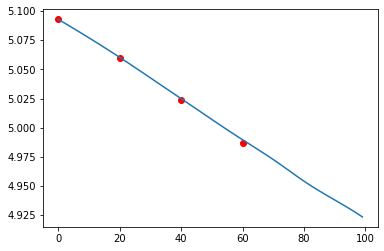

In [83]:
n_Li_acc = [sol.summary_variables["C"] for sol in sol_acc]

fig, ax = plt.subplots()
ax.plot(cycle_nums, n_Li_acc, "ro")
ax.plot(spm_sol_100.summary_variables["C"])
# for k, sol in enumerate(sol_acc):
#     print(sol.summary_variables["n_Li"])
#     print(spm_sol_100.summary_variables["n_Li"][k * n_cycles_step])